
### Задание 1: Реализация фильтра Блума

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib
import random
import matplotlib.pyplot as plt
import math
import mmh3

In [42]:
class BloomFilter:
    def __init__(self, m, k):
        self.m = m
        self.k = k
        self.bit_array = np.zeros(m, dtype=bool)
        self.hash_functions = [self._create_hash_function(i) for i in range(k)]
    
    def _create_hash_function(self, seed):
        def hash_func(item):
            hasher = hashlib.sha256()
            hasher.update(f"{seed}".encode('utf-8'))
            hasher.update(str(item).encode('utf-8'))
            return int(hasher.hexdigest(), 16) % self.m
        return hash_func
    
    def add(self, item):
        for hf in self.hash_functions:
            self.bit_array[hf(item)] = True
    
    def contains(self, item):
        return all(self.bit_array[hf(item)] for hf in self.hash_functions)
    
    def union(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_bf = BloomFilter(self.m, self.k)
        new_bf.bit_array = np.logical_or(self.bit_array, other.bit_array)
        return new_bf
    
    def intersect(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_bf = BloomFilter(self.m, self.k)
        new_bf.bit_array = np.logical_and(self.bit_array, other.bit_array)
        return new_bf

In [43]:
def calculate_false_positive_rate(m, k, added_elements, test_elements):
    bf = BloomFilter(m, k)
    for elem in added_elements:
        bf.add(elem)
    return (sum(1 for elem in test_elements if bf.contains(elem)) / len(test_elements)) * 100

In [44]:
def generate_random_strings(n, seed=None):
    random.seed(seed)
    return [''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=10)) for _ in range(n)]

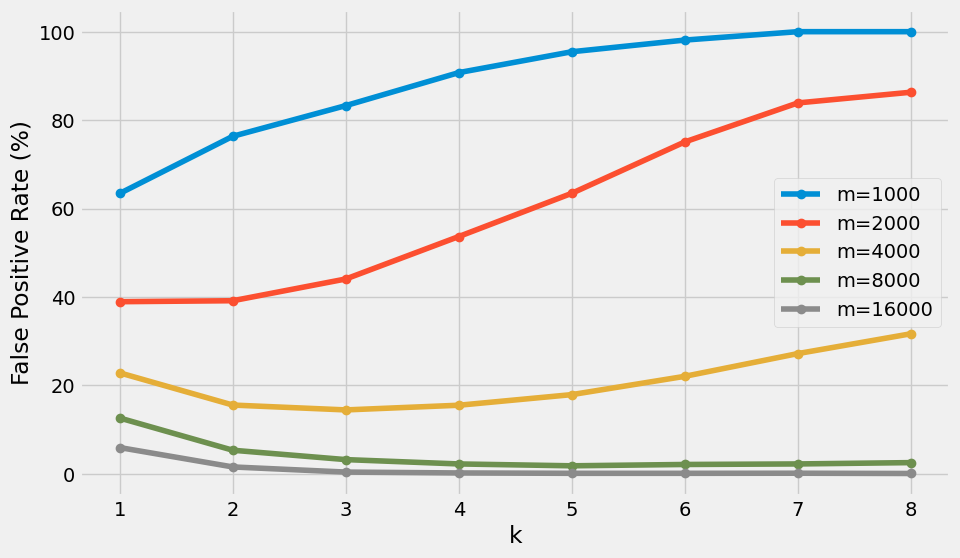

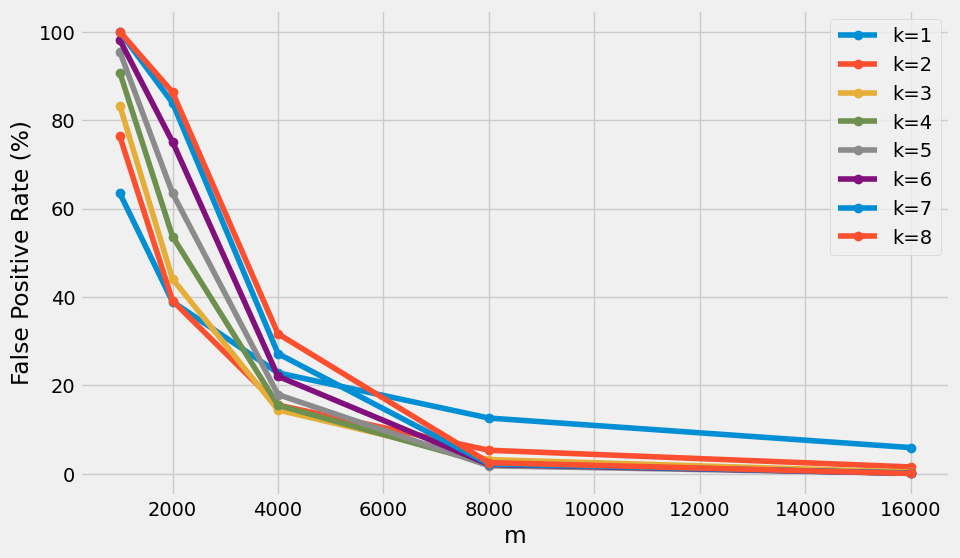

k          1      2      3      4      5      6       7       8
m                                                              
1000   63.42  76.34  83.28  90.74  95.46  98.10  100.00  100.00
2000   38.92  39.14  44.06  53.66  63.44  75.06   83.88   86.30
4000   22.82  15.54  14.44  15.50  17.90  22.04   27.18   31.66
8000   12.60   5.32   3.20   2.22   1.80   2.10    2.22    2.52
16000   5.92   1.54   0.38   0.18   0.10   0.10    0.12    0.06
Объединение содержит 'a' True
Объединение содержит 'b' True
Пересечение содержит 'a': False


In [45]:
n = 1000
test_size = 5000
m_values = [1000, 2000, 4000, 8000, 16000]
k_values = [1, 2, 3, 4, 5, 6, 7, 8]

added_elements = generate_random_strings(n)
test_elements = generate_random_strings(test_size)

assert len(set(added_elements) & set(test_elements)) == 0, "Тестовые элементы не должны пересекаться с добавленными"

results = []
for m in m_values:
    for k in k_values:
        rate = calculate_false_positive_rate(m, k, added_elements, test_elements)
        results.append({'m': m, 'k': k, 'false_positive_rate': rate})

df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
for m in m_values:
    subset = df[df['m'] == m]
    plt.plot(subset['k'], subset['false_positive_rate'], marker='o', label=f'm={m}')
plt.xlabel('k')
plt.ylabel('False Positive Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for k in k_values:
    subset = df[df['k'] == k]
    plt.plot(subset['m'], subset['false_positive_rate'], marker='o', label=f'k={k}')
plt.xlabel('m')
plt.ylabel('False Positive Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

print(df.pivot(index='m', columns='k', values='false_positive_rate'))

bf1 = BloomFilter(1000, 3)
bf1.add("a")
bf2 = BloomFilter(1000, 3)
bf2.add("b")

bf_union = bf1.union(bf2)
print("Объединение содержит 'a'", bf_union.contains("a"))
print("Объединение содержит 'b'", bf_union.contains("b"))
bf_intersection = bf1.intersect(bf2)
print("Пересечение содержит 'a':", bf_intersection.contains("a"))

### Задание 2: Реализация фильтра Блума со счётом

In [46]:
class CountingBloomFilter:
    def __init__(self, m, k):
        self.m = m  
        self.k = k  
        self.counters = np.zeros(m, dtype=int)
        self.hash_functions = [self._create_hash_function(seed) for seed in range(k)]
    
    def _create_hash_function(self, seed):
        def hash_func(item):
            hasher = hashlib.sha256()
            hasher.update(f"{seed}".encode('utf-8'))
            hasher.update(str(item).encode('utf-8'))
            return int(hasher.hexdigest(), 16) % self.m
        return hash_func
    
    def add(self, item):
        for hf in self.hash_functions:
            index = hf(item)
            self.counters[index] += 1
    
    def remove(self, item):
        for hf in self.hash_functions:
            index = hf(item)
            if self.counters[index] > 0:
                self.counters[index] -= 1
    
    def contains(self, item):
        return all(self.counters[hf(item)] > 0 for hf in self.hash_functions)
    
    def union(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_cbf = CountingBloomFilter(self.m, self.k)
        new_cbf.counters = np.maximum(self.counters, other.counters)
        return new_cbf
    
    def intersect(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые параметры m и k")
        new_cbf = CountingBloomFilter(self.m, self.k)
        new_cbf.counters = np.minimum(self.counters, other.counters)
        return new_cbf


In [47]:
def calculate_false_positive_rates(cbf, added_items, removed_items, test_items):
    fp_add = sum(1 for item in test_items if cbf.contains(item))
    fp_add_rate = (fp_add / len(test_items)) * 100 if test_items else 0.0
    
    fp_remove = sum(1 for item in removed_items if cbf.contains(item))
    fp_remove_rate = (fp_remove / len(removed_items)) * 100 if removed_items else 0.0
    
    return fp_add_rate, fp_remove_rate

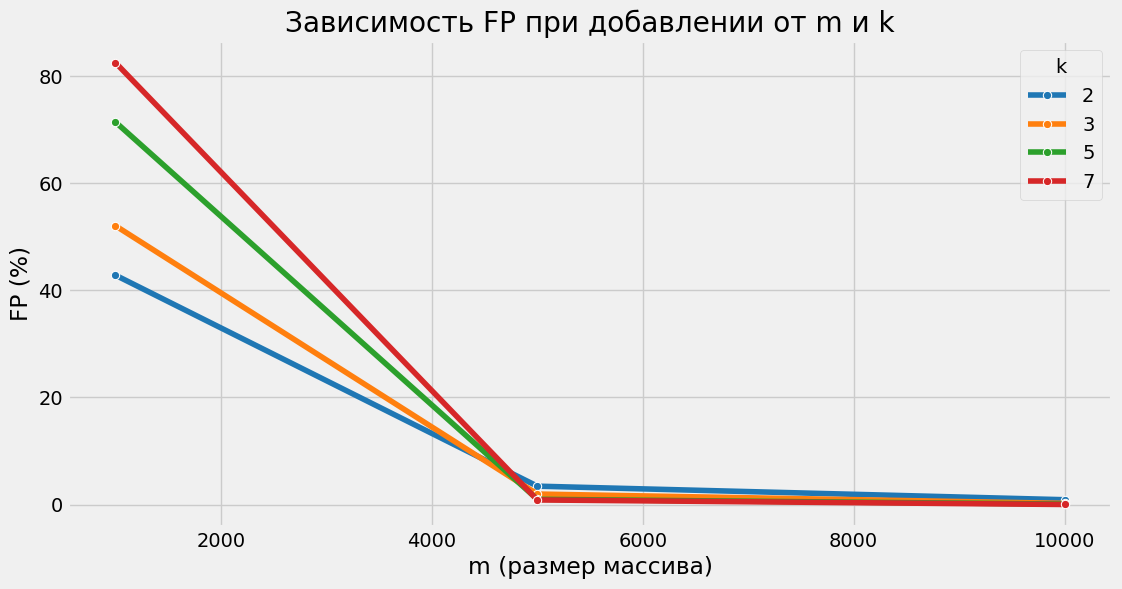

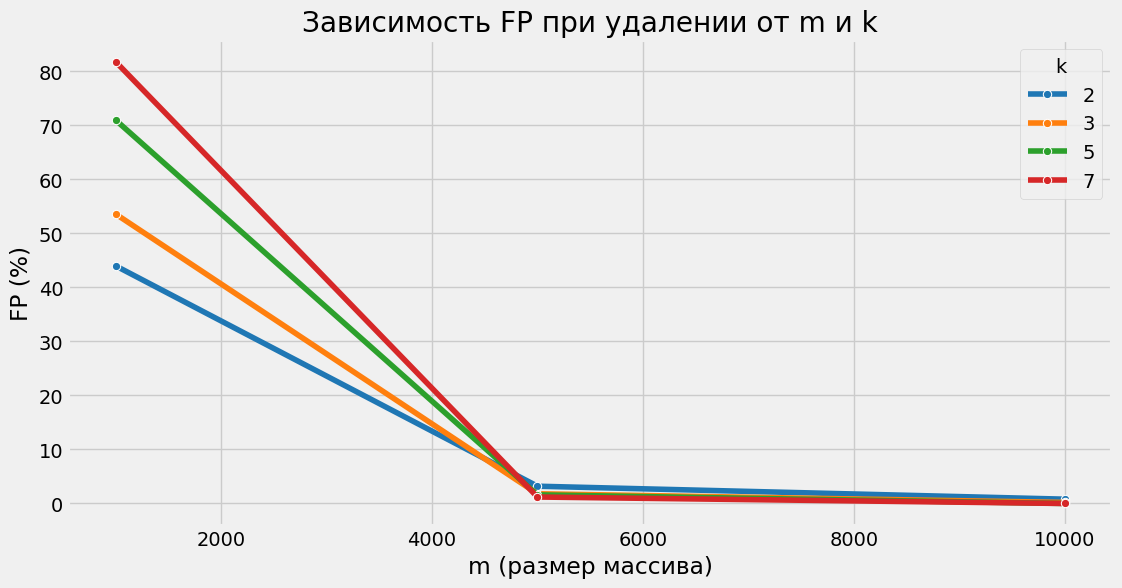

      FP Add (%)                      FP Remove (%)                  
k              2      3      5      7             2     3     5     7
m                                                                    
1000       42.82  52.04  71.40  82.48          44.0  53.6  71.0  81.8
5000        3.45   1.98   1.00   0.88           3.2   1.8   1.6   1.2
10000       0.92   0.24   0.11   0.03           0.8   0.2   0.0   0.0


In [48]:
m_values = [1000, 5000, 10000]
k_values = [2, 3, 5, 7]
num_elements = 1000
num_removed = 500
num_test_elements = 10000


added_items = list(range(num_elements))
removed_items = added_items[:num_removed]
test_items = list(range(num_elements, num_elements + num_test_elements))

assert not set(added_items).intersection(test_items), "Тестовые элементы не должны пересекаться с добавленными"

results = []
for m in m_values:
    for k in k_values:
        cbf = CountingBloomFilter(m, k)
        
        for item in added_items:
            cbf.add(item)
        
        for item in removed_items:
            cbf.remove(item)
        
        fp_add, fp_remove = calculate_false_positive_rates(cbf, added_items, removed_items, test_items)
        results.append({
            'm': m,
            'k': k,
            'FP Add (%)': fp_add,
            'FP Remove (%)': fp_remove
        })

df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='m', y='FP Add (%)', hue='k', marker='o', palette='tab10')
plt.title('Зависимость FP при добавлении от m и k')
plt.xlabel('m (размер массива)')
plt.ylabel('FP (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='m', y='FP Remove (%)', hue='k', marker='o', palette='tab10')
plt.title('Зависимость FP при удалении от m и k')
plt.xlabel('m (размер массива)')
plt.ylabel('FP (%)')
plt.grid(True)
plt.show()

print(df.pivot_table(index='m', columns='k', values=['FP Add (%)', 'FP Remove (%)']))

### Задание 3: HyperLogLog

In [49]:
class HyperLogLog:
    def __init__(self, b=10):
        if b < 4 or b > 16:
            raise ValueError("b должно быть в диапазоне от 4 до 16")
        self.b = b
        self.m = 1 << b
        self.registers = [0] * self.m

    def add(self, element):
        hash_value = mmh3.hash64(str(element).encode('utf-8'), signed=False)[0]
        index = hash_value >> (64 - self.b)
        remaining = hash_value & ((1 << (64 - self.b)) - 1)
        rho = self._count_leading_zeros(remaining)
        if rho > self.registers[index]:
            self.registers[index] = rho

    def _count_leading_zeros(self, w):
        max_bits = 64 - self.b
        if w == 0:
            return max_bits + 1
        return max_bits - w.bit_length() + 1

    def count(self):
        alpha = self._get_alpha()
        sum_inverse = sum(2.0 ** -r for r in self.registers)
        estimate = alpha * (self.m ** 2) / sum_inverse

        if estimate <= 5 * self.m / 2:
            zeros = self.registers.count(0)
            if zeros != 0:
                estimate = self.m * math.log(self.m / zeros)
        elif estimate > (1 << 32) / 30.0:
            estimate = - (1 << 32) * math.log(1 - estimate / (1 << 32))
        return estimate

    def _get_alpha(self):
        if self.b == 4:
            return 0.673
        elif self.b == 5:
            return 0.697
        elif self.b == 6:
            return 0.709
        else:
            return 0.7213 / (1 + 1.079 / self.m)

In [50]:
def evaluate_hll_error(b_values, num_elements=100000):
    results = []
    for b in b_values:
        hll = HyperLogLog(b)
        elements = [str(i) for i in range(num_elements)]
        for elem in elements:
            hll.add(elem)
        estimated = hll.count()
        error = abs(estimated - num_elements) / num_elements * 100
        results.append({
            'b': b,
            'm': 1 << b,
            'Estimated': estimated,
            'Error (%)': error
        })
    return pd.DataFrame(results)

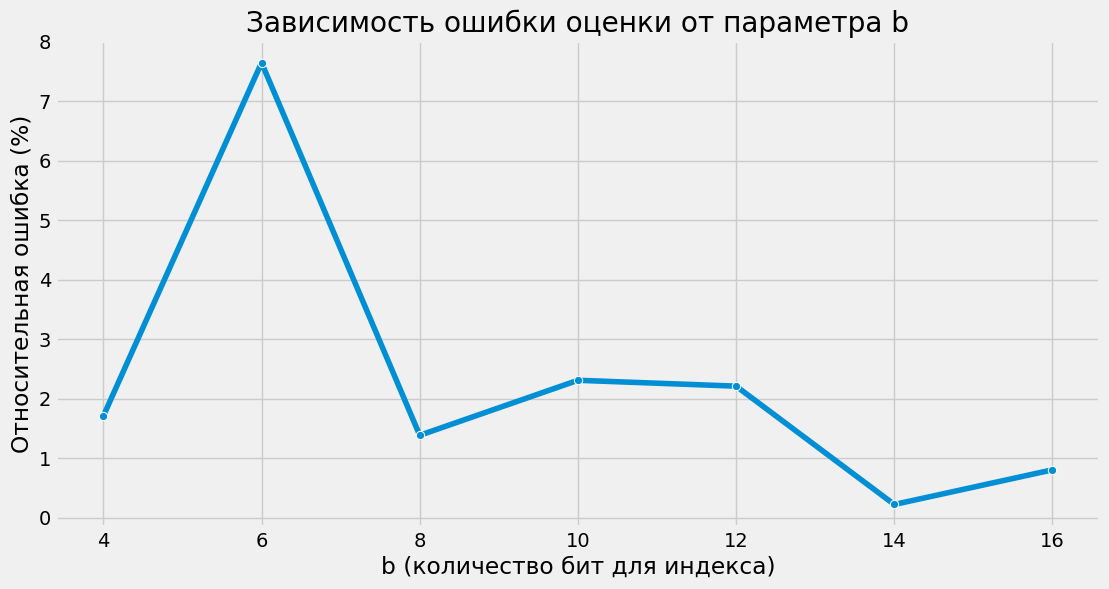

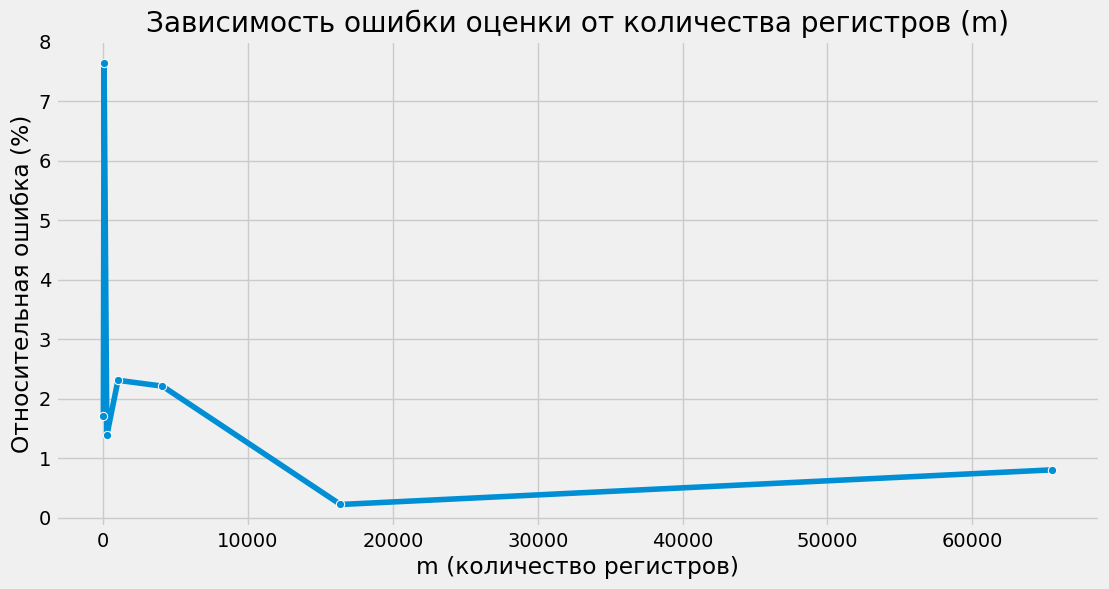

Таблица зависимости ошибки от гиперпараметров:
    b      m  Error (%)
0   4     16   1.707002
1   6     64   7.643671
2   8    256   1.383139
3  10   1024   2.307369
4  12   4096   2.208884
5  14  16384   0.220531
6  16  65536   0.802782


In [51]:
b_values = [4, 6, 8, 10, 12, 14, 16]
df = evaluate_hll_error(b_values)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='b', y='Error (%)', marker='o')
plt.title('Зависимость ошибки оценки от параметра b')
plt.xlabel('b (количество бит для индекса)')
plt.ylabel('Относительная ошибка (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='m', y='Error (%)', marker='o')
plt.title('Зависимость ошибки оценки от количества регистров (m)')
plt.xlabel('m (количество регистров)')
plt.ylabel('Относительная ошибка (%)')
plt.grid(True)
plt.show()

print("Таблица зависимости ошибки от гиперпараметров:")
print(df[['b', 'm', 'Error (%)']])

### Задание 4: QuotientFilter переделай


In [ ]:
import hashlib

class QuotientFilter:
    def __init__(self, q, r):
        self.q = q  
        self.r = r 
        self.size = 1 << q  
        self.table = [(0, False, False, False) for _ in range(self.size)]
    
    def _hash(self, item):
        hash_bytes = hashlib.sha256(str(item).encode()).digest()
        hash_int = int.from_bytes(hash_bytes, byteorder='big')
        fingerprint = hash_int & ((1 << (self.q + self.r)) - 1)
        return fingerprint >> self.r, fingerprint & ((1 << self.r) - 1)
    
    def _find_run_start(self, idx):
        while self.table[idx][2]: 
            idx = (idx - 1) % self.size
        return idx
    
    def add(self, item):
        q, r = self._hash(item)
        entry = self.table[q]
        
        if not entry[1]:
            self.table[q] = (r, True, False, True)
            return
        
        current = self._find_run_start(q)
        while True:
            val, occ, cont, end = self.table[current]
            if val == r and not cont:  
                return
            if end:  
                break
            current = (current + 1) % self.size
    
        self._shift_and_insert(current, r)
    
    def _shift_and_insert(self, pos, r):
        temp = []
        current = pos
        
        while not self.table[current][3]:  
            temp.append(self.table[current][0]) 
            current = (current + 1) % self.size
        
    
        temp.append(r)
        current = pos
        
       
        for i, val in enumerate(temp):
            self.table[current] = (
                val,
                True, 
                i > 0,
                i == len(temp) - 1  
            )
            current = (current + 1) % self.size
    
    def contains(self, item):
        q, r = self._hash(item)
        entry = self.table[q]
        
        if not entry[1]:
            return False
        
        current = self._find_run_start(q)
        while True:
            val, _, cont, end = self.table[current]
            if val == r and not cont:
                return True
            if end:
                break
            current = (current + 1) % self.size
        return False
    
    def __contains__(self, item):
        return self.contains(item)

In [53]:
def calculate_fpr(qf, test_items):
    fp = sum(1 for item in test_items if qf.contains(item))
    return (fp / len(test_items)) * 100

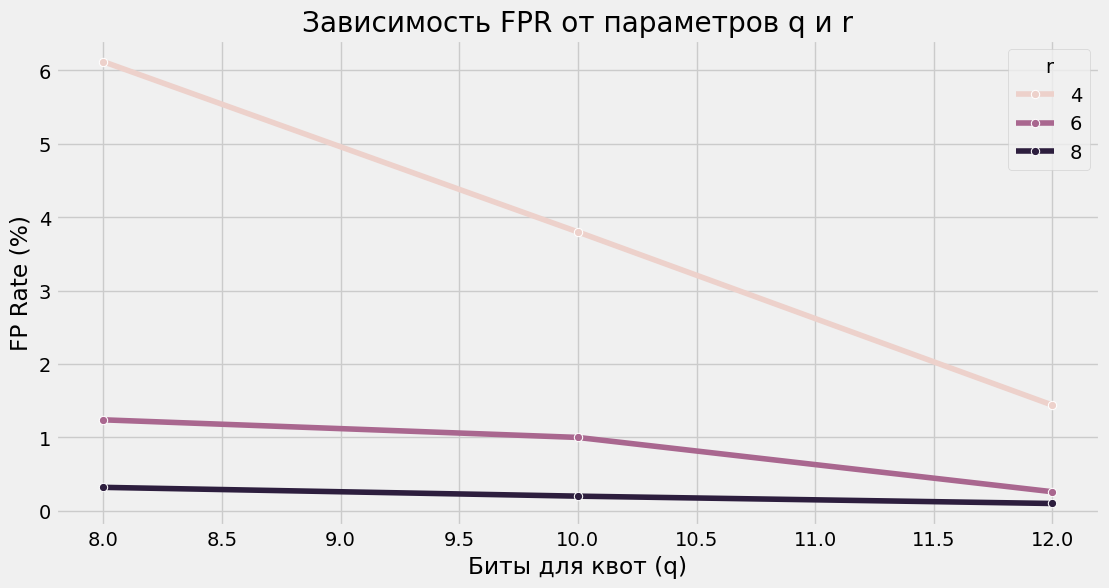

Таблица результатов:
r      4     6     8
q                   
8   6.12  1.24  0.32
10  3.80  1.00  0.20
12  1.44  0.26  0.10


In [54]:
def evaluate_parameters(q_values, r_values, num_elements=1000, num_tests=5000):
    results = []
    added_items = [f"item_{i}" for i in range(num_elements)]
    test_items = [f"test_{i}" for i in range(num_tests)]
    
    for q in q_values:
        for r in r_values:
            qf = QuotientFilter(q, r)
            for item in added_items:
                qf.add(item)
            
            fp_rate = calculate_fpr(qf, test_items)
            results.append({
                'q': q,
                'r': r,
                'FP Rate (%)': fp_rate
            })
    
    return pd.DataFrame(results)

df = evaluate_parameters(
    q_values=[8, 10, 12], 
    r_values=[4, 6, 8]
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='q', y='FP Rate (%)', hue='r', marker='o')
plt.title("Зависимость FPR от параметров q и r")
plt.xlabel("Биты для квот (q)")
plt.grid(True)
plt.show()

print("Таблица результатов:")
print(df.pivot(index='q', columns='r', values='FP Rate (%)'))

### Задание 5: CountMinSketch

In [55]:
class CountMinSketch:
    def __init__(self, width, depth):
        self.width = width
        self.depth = depth
        self.counters = np.zeros((depth, width), dtype=np.int32)
        self.seeds = [random.randint(0, 2**32 - 1) for _ in range(depth)]
    
    def _hash(self, item, seed):
        return mmh3.hash(str(item), seed, signed=False) % self.width
    
    def add(self, item):
        for i in range(self.depth):
            h = self._hash(item, self.seeds[i])
            self.counters[i][h] += 1
    
    def estimate(self, item):
        return min(
            self.counters[i][self._hash(item, self.seeds[i])]
            for i in range(self.depth)
        )
    
    def merge(self, other):
        if self.width != other.width or self.depth != other.depth:
            raise ValueError("Count-Min Sketches must have the same dimensions")
        merged = CountMinSketch(self.width, self.depth)
        merged.counters = self.counters + other.counters
        return merged

In [56]:
def calculate_false_positive_rate(cms, added_set, test_items):
    fp = 0
    for item in test_items:
        if cms.estimate(item) > 0 and item not in added_set:
            fp += 1
    return (fp / len(test_items)) * 100

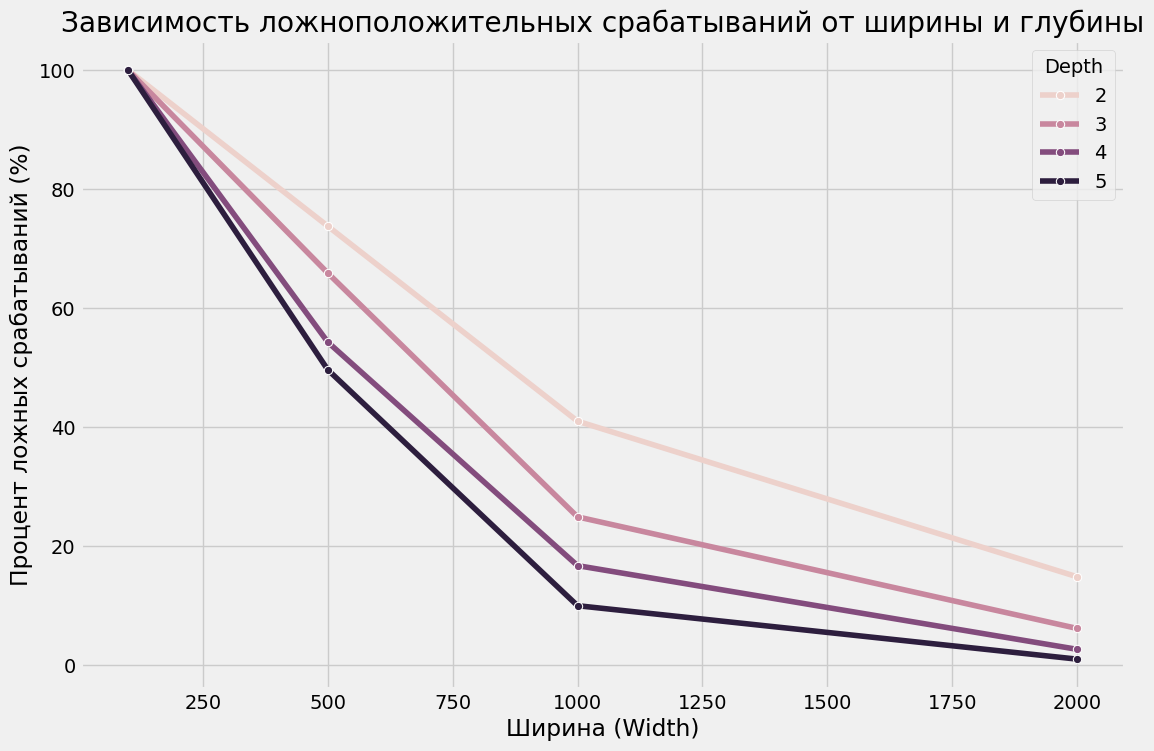

Depth       2       3       4       5
Width                                
100    100.00  100.00  100.00  100.00
500     73.77   65.89   54.29   49.64
1000    41.00   24.92   16.73   10.00
2000    14.86    6.18    2.67    1.02


In [57]:
num_elements = 1000
num_test_elements = 10000
width_values = [100, 500, 1000, 2000]
depth_values = [2, 3, 4, 5]

added_items = list(range(num_elements))
added_set = set(added_items)
test_items = list(range(num_elements, num_elements + num_test_elements))

assert set(test_items).isdisjoint(added_set), "Тестовые элементы не должны быть в добавленных"

results = []
for width in width_values:
    for depth in depth_values:
        cms = CountMinSketch(width, depth)
        for item in added_items:
            cms.add(item)
        fp_rate = calculate_false_positive_rate(cms, added_set, test_items)
        results.append({
            'Width': width,
            'Depth': depth,
            'FP Rate (%)': fp_rate
        })

df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Width', y='FP Rate (%)', hue='Depth', marker='o')
plt.title('Зависимость ложноположительных срабатываний от ширины и глубины')
plt.xlabel('Ширина (Width)')
plt.ylabel('Процент ложных срабатываний (%)')
plt.grid(True)
plt.show()

pivot_table = df.pivot(index='Width', columns='Depth', values='FP Rate (%)')
print(pivot_table)

### Задание 6: MinHash

In [58]:
class MinHash:
    def __init__(self, num_hashes):
        self.num_hashes = num_hashes
        self.seeds = np.random.randint(0, 1000000, num_hashes)

    def _hash(self, item, seed):
        hash_value = int(hashlib.md5((str(item) + str(seed)).encode()).hexdigest(), 16)
        return hash_value

    def compute_signature(self, items):
        signature = np.full(self.num_hashes, np.inf)
        for item in items:
            for i in range(self.num_hashes):
                hash_value = self._hash(item, self.seeds[i])
                if hash_value < signature[i]:
                    signature[i] = hash_value
        return signature

    def similarity(self, set1, set2):
        sig1 = self.compute_signature(set1)
        sig2 = self.compute_signature(set2)
        return np.mean(sig1 == sig2)

In [59]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

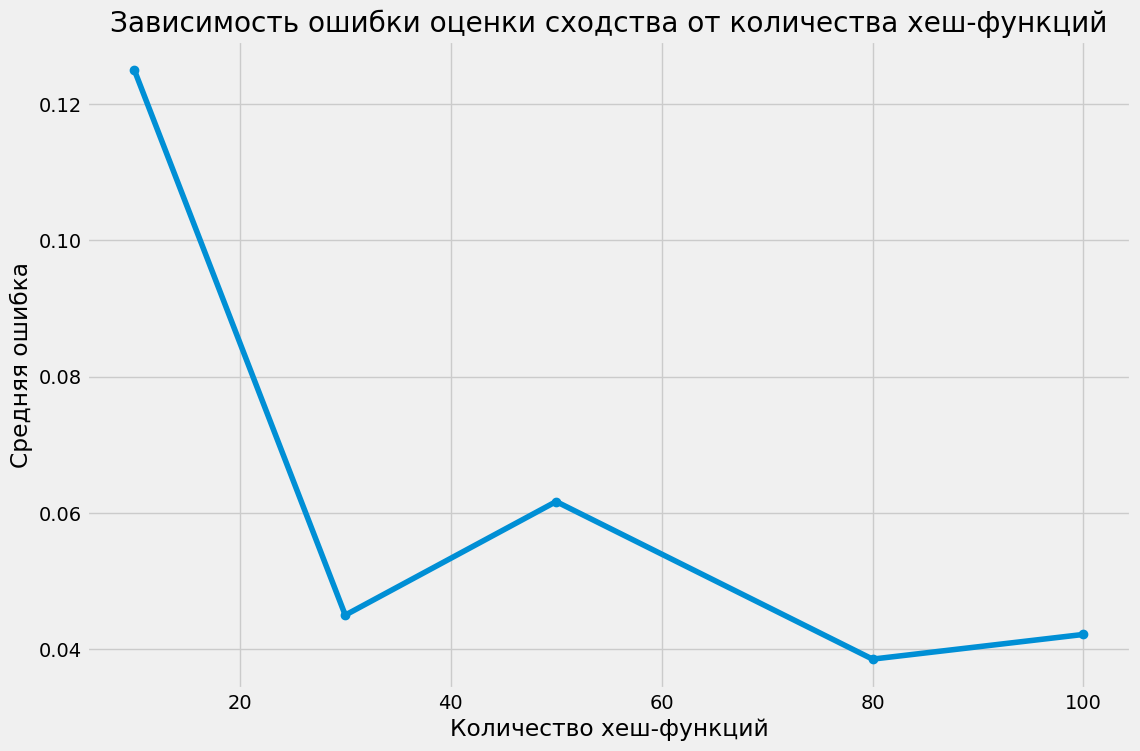

   Number of Hashes  Average Error
0                10       0.125000
1                30       0.045000
2                50       0.061667
3                80       0.038542
4               100       0.042167


In [60]:
num_hashes_values = [10, 30, 50, 80, 100]
num_elements = 100
num_trials = 20

set1 = set(range(num_elements))
set2 = set(range(num_elements // 2, num_elements + num_elements // 2)) 

true_jaccard = jaccard_similarity(set1, set2)

results = []

for num_hashes in num_hashes_values:
    errors = []
    for _ in range(num_trials):
        minhash = MinHash(num_hashes)
        estimated_jaccard = minhash.similarity(set1, set2)
        error = abs(estimated_jaccard - true_jaccard)
        errors.append(error)
    avg_error = np.mean(errors)
    results.append((num_hashes, avg_error))

df = pd.DataFrame(results, columns=['Number of Hashes', 'Average Error'])

plt.figure(figsize=(12, 8))
plt.plot(df['Number of Hashes'], df['Average Error'], marker='o')
plt.title('Зависимость ошибки оценки сходства от количества хеш-функций')
plt.xlabel('Количество хеш-функций')
plt.ylabel('Средняя ошибка')
plt.grid(True)
plt.show()

print(df)